In [1]:
import pandas as pd
import re
from tqdm.auto import tqdm
import yfinance as yf
import swifter
import numpy as np
from collections import OrderedDict

#載入PCA套件
from sklearn.decomposition import PCA

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
tmp = pd.read_excel('Data/codes.xlsx', header = 1)
del tmp['#']
db = dict()
for i in range(0,len(tmp)):
    if tmp['英文代碼'][i] not in db.keys():
        db[tmp['英文代碼'][i]] = []
    db[tmp['英文代碼'][i]] =tmp['中文簡稱'][i]


In [46]:
df = pd.DataFrame()
for i in range(2011, 2023):
    try:
        df_ = pd.read_csv('Data/'+str(i)+'_fut.csv', encoding = 'cp950', index_col = 0, low_memory=False)[['契約', '到期月份(週別)', '開盤價', '最高價', '最低價', '收盤價', '漲跌價', '漲跌%', '成交量','結算價', '未沖銷契約數', '最後最佳買價', '最後最佳賣價', '歷史最高價', '歷史最低價']]
    except:
        print(i)
        df_ = pd.read_csv('Data/'+str(i)+'_fut.csv', low_memory=False , index_col = 0)
    df = pd.concat([df,df_])

2018
2019
2020
2021
2022


In [47]:
df['中文名稱'] = df['契約'].apply(lambda x: db[x])
df['Type'] = df['中文名稱'].apply(lambda x: 0 if x in ['非金電期貨', '臺股期貨', '臺幣黃金期貨', '金融期貨', '電子期貨', '臺灣50期貨', '小型臺指期貨', '櫃買期貨', '黃金期貨', '十年期公債期貨', '三十天期利率期貨', '摩臺期'] else 1)
df['Type_'] = df['到期月份(週別)'].apply(lambda x: 0 if '/' in str(x) else 1)
df = df[(df['Type'] == 1) & (df['Type_'] == 1) & (df.index != '')] 
df.index = pd.to_datetime(df.index) 

In [48]:
filter1 = re.compile(r'(.*?)[期]')
re.findall(filter1, '中信金期貨')
df['中文名稱'] = df['中文名稱'].apply(lambda x: re.findall(filter1, x)[0])
df['交易日期'] = df.index

In [6]:
TEJ = pd.read_excel('Data/TEJ_20231126.xlsx')

In [7]:
filter2 = re.compile(r'(.*?)[證]')
TEJ['名稱'] = TEJ['名稱'].apply(lambda x: re.findall(filter2, x)[0] if x[-2:] == '證券' else x)
TEJ['財報發布日'] = pd.to_datetime(TEJ['財報發布日']) 

In [8]:
def find_closest_date(target_date, dates):
    try:
        tmp = dates.iloc[(dates - target_date).abs().argsort()[:1]].values[0]
    except:
        tmp = 'None'
    return tmp

In [9]:
# df['財報發布日']  = df.apply(lambda x: find_closest_date(x['交易日期'],TEJ['財報發布日'][TEJ['名稱'] == x['中文名稱']]), axis = 1)


df['財報發布日']  = df.swifter.apply(lambda x: find_closest_date(x['交易日期'],TEJ['財報發布日'][TEJ['名稱'] == x['中文名稱']]), axis = 1)

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "
Pandas Apply: 100%|██████████| 3356904/3356904 [3:04:47<00:00, 302.75it/s]  


In [10]:
df.to_csv('df_merge.csv', index =False)

In [11]:

# tmps = []
# error_tmps = []
# pbar = tqdm(df.iterrows(), total = (len(df)))
# for index, row in pbar:
#     try:
#         tmp = find_closest_date(row['交易日期'], TEJ['財報發布日'][TEJ['名稱'] == row['中文名稱']])
#         tmps.append(tmp)
#     except:
#         error_tmps.append(row['中文名稱'])

In [12]:
df['財報發布日'] = df['財報發布日'].apply(lambda x: np.nan if x == 'None' else x)
df['財報發布日'] = pd.to_datetime(df['財報發布日'])

# 直接從這裏跑

In [2]:
TEJ = pd.read_excel('Data/TEJ_20231126.xlsx')
filter2 = re.compile(r'(.*?)[證]')
TEJ['名稱'] = TEJ['名稱'].apply(lambda x: re.findall(filter2, x)[0] if x[-2:] == '證券' else x)
TEJ['財報發布日'] = pd.to_datetime(TEJ['財報發布日']) 

KeyboardInterrupt: 

In [ ]:
df = pd.read_csv('df_merge.csv')
df['交易時段'] = df['交易時段'].fillna('一般')
df = df[df['交易時段'] == '一般']
df['財報發布日'] = df['財報發布日'].apply(lambda x: np.nan if x == 'None' else x)
df['財報發布日'] = pd.to_datetime(df['財報發布日'])

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (8,9,10,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data_code = pd.read_excel('Data/股名代碼.xlsx', header = 2)

In [ ]:
data_code = data_code.T.reset_index(drop=True).T

In [ ]:
tmp_1 = []
tmp_2 = []
tmp_3 = []
for i in range(0, len(data_code.T)):
    for j in range(0,len(data_code[i])):
        if pd.isna(data_code[i][j]) == False:
            if i%2 == 0:
                tmp_1.append(data_code[i][j].split('\xa0')[0])
            else:
                tmp_2.append(data_code[i][j].split('\xa0')[0])

df_code = pd.DataFrame()

In [ ]:
df_code = pd.DataFrame()
df_code['code'] = tmp_1
df_code['name'] = tmp_2

tmp_3 = []
tmp_4 = []
market = ''
sector = '' 
for i in range(len(tmp_1)):
    if tmp_1[i] == '上市' or tmp_1[i] == '上櫃':
       market = tmp_1[i]
       sector = tmp_2[i]
    tmp_3.append(market)
    tmp_4.append(sector)

df_code['sector'] = tmp_4
df_code['market'] = tmp_3
df_code['name'] = df_code['name'].apply(lambda x: str(x.split("＊")[0]) if len(x.split("＊"))>0 else str(x))
df_code['name'] = df_code['name'].apply(lambda x: str(x.split("＃")[0]) if len(x.split("＃"))>0 else str(x))

In [ ]:
df_name = list(set(df['中文名稱']))
name_dict = {}
for name in df_name:
    if name not in name_dict.keys():
        name_dict[name] = []
    if len(df_code['code'][(name == df_code['name'])]) > 0:
        name_dict[name] = df_code['code'][(name == df_code['name'])].iloc[0]
df['code'] = df['中文名稱'].apply(lambda x: name_dict[x])

In [ ]:
DB = pd.merge(df,TEJ,left_on = ['中文名稱','財報發布日'], right_on = ['名稱','財報發布日'])

In [ ]:
DB['收盤價'] = DB.swifter.apply(lambda x: x['收盤價'] if x['收盤價'] != '-' else x['結算價'], axis = 1) # 若當日流動量不足,改用結算價替代
DB['收盤價'] = DB['收盤價'].astype(float)

Pandas Apply: 100%|██████████| 3534900/3534900 [00:27<00:00, 127269.47it/s]


In [ ]:
# 定义一个函数来计算百分比变化 # gpt 好棒
def calculate_pct_change(group):
    group['Return'] = group['收盤價'].pct_change()
    return group

# 使用 groupby 和 apply 来应用这个函数
DB = DB.groupby(['契約', '到期月份(週別)']).apply(calculate_pct_change)

In [ ]:
DB_tmp = DB[['契約', '到期月份(週別)', '交易日期', 'Return']]

In [ ]:
DB_tmp['交易日期'] = pd.to_datetime(DB_tmp['交易日期'])

# 使用 pivot_table 来重塑 DataFrame
pivot_df = DB_tmp.pivot_table(index='交易日期', columns=['契約', '到期月份(週別)'], values='Return')


/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# pivot_df.to_pickle("pivot_df.pkl")

In [7]:
tmp_df  = pd.read_pickle('pivot_df.pkl')

# 找產業別, 組成Sector (可能採按市值加權)

In [ ]:
codes_chinese = pd.read_excel('Data/codes_sector.xlsx', header = 1)

In [ ]:
codes_chinese['選擇權'] = codes_chinese['中文簡稱'].apply( lambda x : 0 if ('W' in x or '選' in x) else 1)
codes_chinese = codes_chinese[codes_chinese['選擇權'] == 1]
del codes_chinese['選擇權']
codes_chinese = codes_chinese.reset_index()
codes_chinese = codes_chinese[['英文代碼','中文簡稱']]
index = codes_chinese[codes_chinese['中文簡稱'] == '小型臺指']['中文簡稱'].index[0]
codes_chinese.loc[index, '中文簡稱'] = '小型臺指期貨'

In [ ]:
sectors = pd.read_excel('Data/TEJ_產業別.xlsx')
sectors['產業類別'] = sectors['TSE新產業_名稱'].fillna(sectors['TEJ產業_名稱'])
filter2 = re.compile(r'(.*?)[證]')
sectors['名稱_'] = sectors['名稱'].apply(lambda x: re.findall(filter2, x)[0] if x[-2:] == '證券' else x)

In [ ]:
filter3 = re.compile(r'(.*?)[期]')
codes_chinese['中文簡稱'] = codes_chinese['中文簡稱'].apply(lambda x: re.findall(filter3, x)[0])

In [ ]:
codes_chinese['產業'] = 0
for i in range(len(codes_chinese['中文簡稱'])):
    tmp = codes_chinese['中文簡稱'][i]
    for j in range(len(sectors['產業類別'])):
        sector = sectors['產業類別'][j]
        if tmp in sectors['名稱_'][j]:
            codes_chinese['產業'][i] = sector
            break

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# 按照Sector分類，將同樣Sector之股票期貨return 組為一組return

In [6]:
tmps = list(tmp_df.T.index)
new_index = []
for tmp in tmps:
    name = tmp[0]
    new = list(tmp)
    industry = codes_chinese[codes_chinese['英文代碼'] == name]['產業'].values[0]
    new.append(industry)
    new_index.append(tuple(new))
    
new_df = tmp_df.T
new_df.index = pd.MultiIndex.from_tuples(new_index, names=['契約', '到期月份(週別)', '產業別'])
new_df = new_df.T

NameError: name 'tmp_df' is not defined

In [4]:
all_future = list(set(new_df.keys().get_level_values('契約')))
futures = []
for future in all_future:
    if future[2] == 'F':
        futures.append(future)
new_df = new_df[futures]

NameError: name 'new_df' is not defined

In [2]:
test_df = new_df.xs((201309,'塑膠工業'), level = ('到期月份(週別)','產業別'), axis = 1)

NameError: name 'new_df' is not defined

In [319]:
test_df['Sum'] = test_df.sum(axis = 1)

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [3]:
test_df

NameError: name 'test_df' is not defined

<AxesSubplot:xlabel='交易日期'>

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  func(*args, **kwargs)
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from current font.
  func(*args, **kwargs)
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  func(*args, **kwargs)
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  func(*args, **kwargs)
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 22865 (\N{CJK UNIFIED IDEOGRAPH-5951}) missing from current font.
  func(*args, **kwargs)
/home/akil

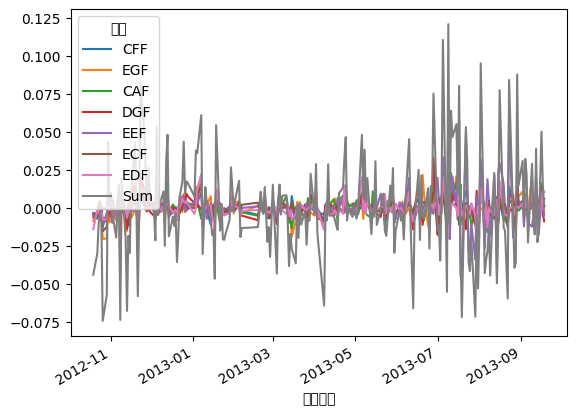

In [326]:
test_df[test_df['Sum']!= 0].plot()

In [ ]:
#輸入有多少成分我們想要留住分解
pca = PCA(n_components=2)

#將資料分成兩個主成份
pca.fit(pivot_df)
x_pca = pca.transform(pivot_df)

NameError: name 'pivot_df' is not defined

In [ ]:
# pivot_df.cumsum().plot() 

<AxesSubplot:xlabel='交易日期'>

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  func(*args, **kwargs)
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from current font.
  func(*args, **kwargs)
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  func(*args, **kwargs)
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  func(*args, **kwargs)
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Glyph 22865 (\N{CJK UNIFIED IDEOGRAPH-5951}) missing from current font.
  func(*args, **kwargs)
/home/akil

ValueError: Image size of 546x659617 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>